Soucres:
https://www.kaggle.com/code/matheusparracho/decathlon-heart-segmentation-unet3d#Importing-and-treating-the-data

https://saturncloud.io/blog/how-to-use-kfold-cross-validation-with-dataloaders-in-pytorch/#implementing-k-fold-cross-validation-using-dataloaders-in-pytorch (only implementation, actual Cross-validation is weird) 

In [1]:
import torch
import os
from sklearn.model_selection import KFold
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    Spacingd,
    DivisiblePadd,
    RandAffined,
    RandRotated,
    RandGaussianNoised
)
from monai.data import CacheDataset, DataLoader
from torch.utils.data import ConcatDataset
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceCELoss
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib
import numpy as np
from torchmetrics import Dice

2024-10-10 09:33:50.606969: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 09:33:50.623207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 09:33:50.646864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 09:33:50.646885: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 09:33:50.662030: I tensorflow/core/platform/cpu_feature_gua

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Hyperparameters

In [3]:
DATA_DIR = "/dataset/"
TRAIN_IMAGES = "imagesTr"
TRAIN_LABELS ="labelsTr"
TEST_IMAGES = "imagesTs"
K_FOLDS = 4
BATCH_SIZE = 1
IN_CHANNELS = 1
LABELS_AMOUNT = 2
MAX_EPOCHS = 30
PATIENCE = 3
EARLY_STOPPING_MIN_DELTA = 0.3
SPARTIAL_DIMENSIONS = 3
LEARNING_RATE = 1e-4
DROPOUT = 0.2

In [4]:
train_images = sorted(os.listdir(os.path.join(DATA_DIR, TRAIN_IMAGES)))
train_labels = sorted(os.listdir(os.path.join(DATA_DIR, TRAIN_LABELS)))
data_dicts = [{"image": os.path.join(DATA_DIR, TRAIN_IMAGES ,image_name), "label": os.path.join(DATA_DIR, TRAIN_LABELS, label_name)} for image_name, label_name in zip(train_images, train_labels)]
train_files, test_files = data_dicts[:-4], data_dicts[-4:] # 16 train and 4 test
train_files[1],train_files[5],train_files[-1]

({'image': '/dataset/imagesTr/la_004.nii.gz',
  'label': '/dataset/labelsTr/la_004.nii.gz'},
 {'image': '/dataset/imagesTr/la_010.nii.gz',
  'label': '/dataset/labelsTr/la_010.nii.gz'},
 {'image': '/dataset/imagesTr/la_023.nii.gz',
  'label': '/dataset/labelsTr/la_023.nii.gz'})

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),        
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(["image", "label"], 16)
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(["image", "label"], 16)
    ]
)

augm_transforms = Compose(
    [
        RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        RandGaussianNoised(keys='image', prob=0.5),
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(["image", "label"], 16)
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## CREATE DATASET
Train and validation dataloaders are created in cross-validation loop

In [6]:
train_ds = CacheDataset(data=train_files, transform=train_transforms)
augm_ds = CacheDataset(data=train_files, transform=[train_transforms, augm_transforms])
train_ds = ConcatDataset([train_ds, augm_ds])

test_ds = CacheDataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds)

Loading dataset: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


## Early stopper class

In [7]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float("inf")

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=PATIENCE, min_delta=EARLY_STOPPING_MIN_DELTA)

## TODO CHANGE/CHECK MODEL

In [8]:
model = UNet(
    spatial_dims = SPARTIAL_DIMENSIONS,
    in_channels = IN_CHANNELS,
    out_channels = LABELS_AMOUNT,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    dropout = DROPOUT,
    norm = Norm.BATCH,
).to(device)
loss_function = DiceCELoss(to_onehot_y = True, softmax = True)
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, amsgrad = True)

Create folds for crossvalidation

In [9]:
kf = KFold(n_splits = K_FOLDS, shuffle = True)

Cross validation loop

In [10]:
total_epoch_loss_values = []
total_losses_validation = []

for fold, (train_idx, test_idx) in enumerate(kf.split(train_files)):
    print("-" * 40)
    print(f"Fold {fold + 1}")

    train_loader = DataLoader(
        dataset = train_ds,
        batch_size = BATCH_SIZE,
        sampler = torch.utils.data.SubsetRandomSampler(train_idx),
    )

    val_loader = DataLoader(
        dataset = train_ds,
        batch_size = BATCH_SIZE,
        sampler = torch.utils.data.SubsetRandomSampler(test_idx),
    )

    epoch_loss_values = []
    losses_validation = []

    for epoch in range(MAX_EPOCHS):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{MAX_EPOCHS}")
        model.train()
        epoch_loss = 0
        step = 0
        
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            #loss.item -> each batch loss
            epoch_loss += loss.item()
    
        # saving the loss for the actual epoch
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        
    
        model.eval()
        with torch.no_grad():
            loss_val = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                #get the loss to the validation set
                outputs = model(val_inputs)
                loss_val = loss_function(outputs, val_labels).item()
            
            loss_val_avg = loss_val / val_loader.batch_size
            losses_validation.append(loss_val_avg)
            print(f"validation average loss: {loss_val_avg:.4f}")
            if early_stopper.early_stop(loss_val_avg):
                print("early stopped!")
                break

    total_epoch_loss_values.extend(epoch_loss_values)
    total_losses_validation.extend(losses_validation)


----------------------------------------
Fold 1
----------
epoch 1/30
epoch 1 average loss: 1.5115
validation average loss: 1.4743
----------
epoch 2/30
epoch 2 average loss: 1.4742
validation average loss: 1.4073
----------
epoch 3/30
epoch 3 average loss: 1.4425
validation average loss: 1.3801
----------
epoch 4/30
epoch 4 average loss: 1.4151
validation average loss: 1.3634
----------
epoch 5/30
epoch 5 average loss: 1.3909
validation average loss: 1.3333
----------
epoch 6/30
epoch 6 average loss: 1.3699
validation average loss: 1.3260
----------
epoch 7/30
epoch 7 average loss: 1.3510
validation average loss: 1.3069
----------
epoch 8/30
epoch 8 average loss: 1.3328
validation average loss: 1.2769
----------
epoch 9/30
epoch 9 average loss: 1.3142
validation average loss: 1.2484
----------
epoch 10/30
epoch 10 average loss: 1.2964
validation average loss: 1.2512
----------
epoch 11/30
epoch 11 average loss: 1.2787
validation average loss: 1.2520
----------
epoch 12/30
epoch 12 ave

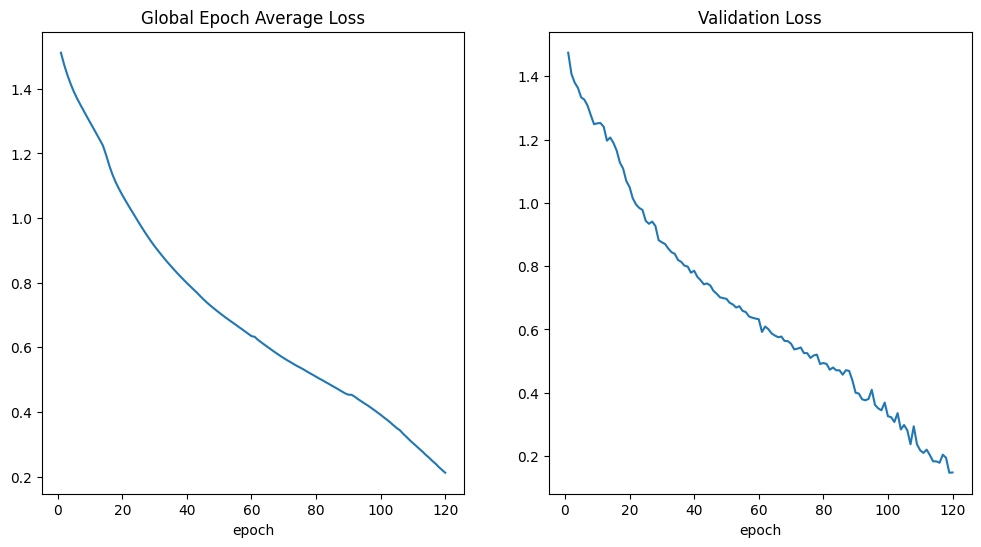

In [12]:
%matplotlib inline
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Global Epoch Average Loss")
x = [i + 1 for i in range(len(total_epoch_loss_values))]
y = total_epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation Loss")
x = [i + 1 for i in range(len(total_losses_validation))]
y = total_losses_validation
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## TODO ADD TEST COMPARISON
Current idéas:

Calculate same metric as in paper (Dice score)

In [13]:
nifti_images = []
nifti_outputs = []
nifti_labels = []
for test_data in test_loader: 
    test_inputs, test_labels = (
        test_data["image"].to(device),
        test_data["label"].to(device),
    )
    nifti_images.append(nib.Nifti1Image(test_inputs.cpu().numpy().squeeze(), affine=np.eye(4)))
    nifti_outputs.append(nib.Nifti1Image(torch.argmax(model(test_inputs).cpu(), dim=1).numpy().squeeze().astype(np.int32), affine=np.eye(4)))
    nifti_labels.append(nib.Nifti1Image(test_labels.cpu().numpy().squeeze(), affine=np.eye(4)))

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



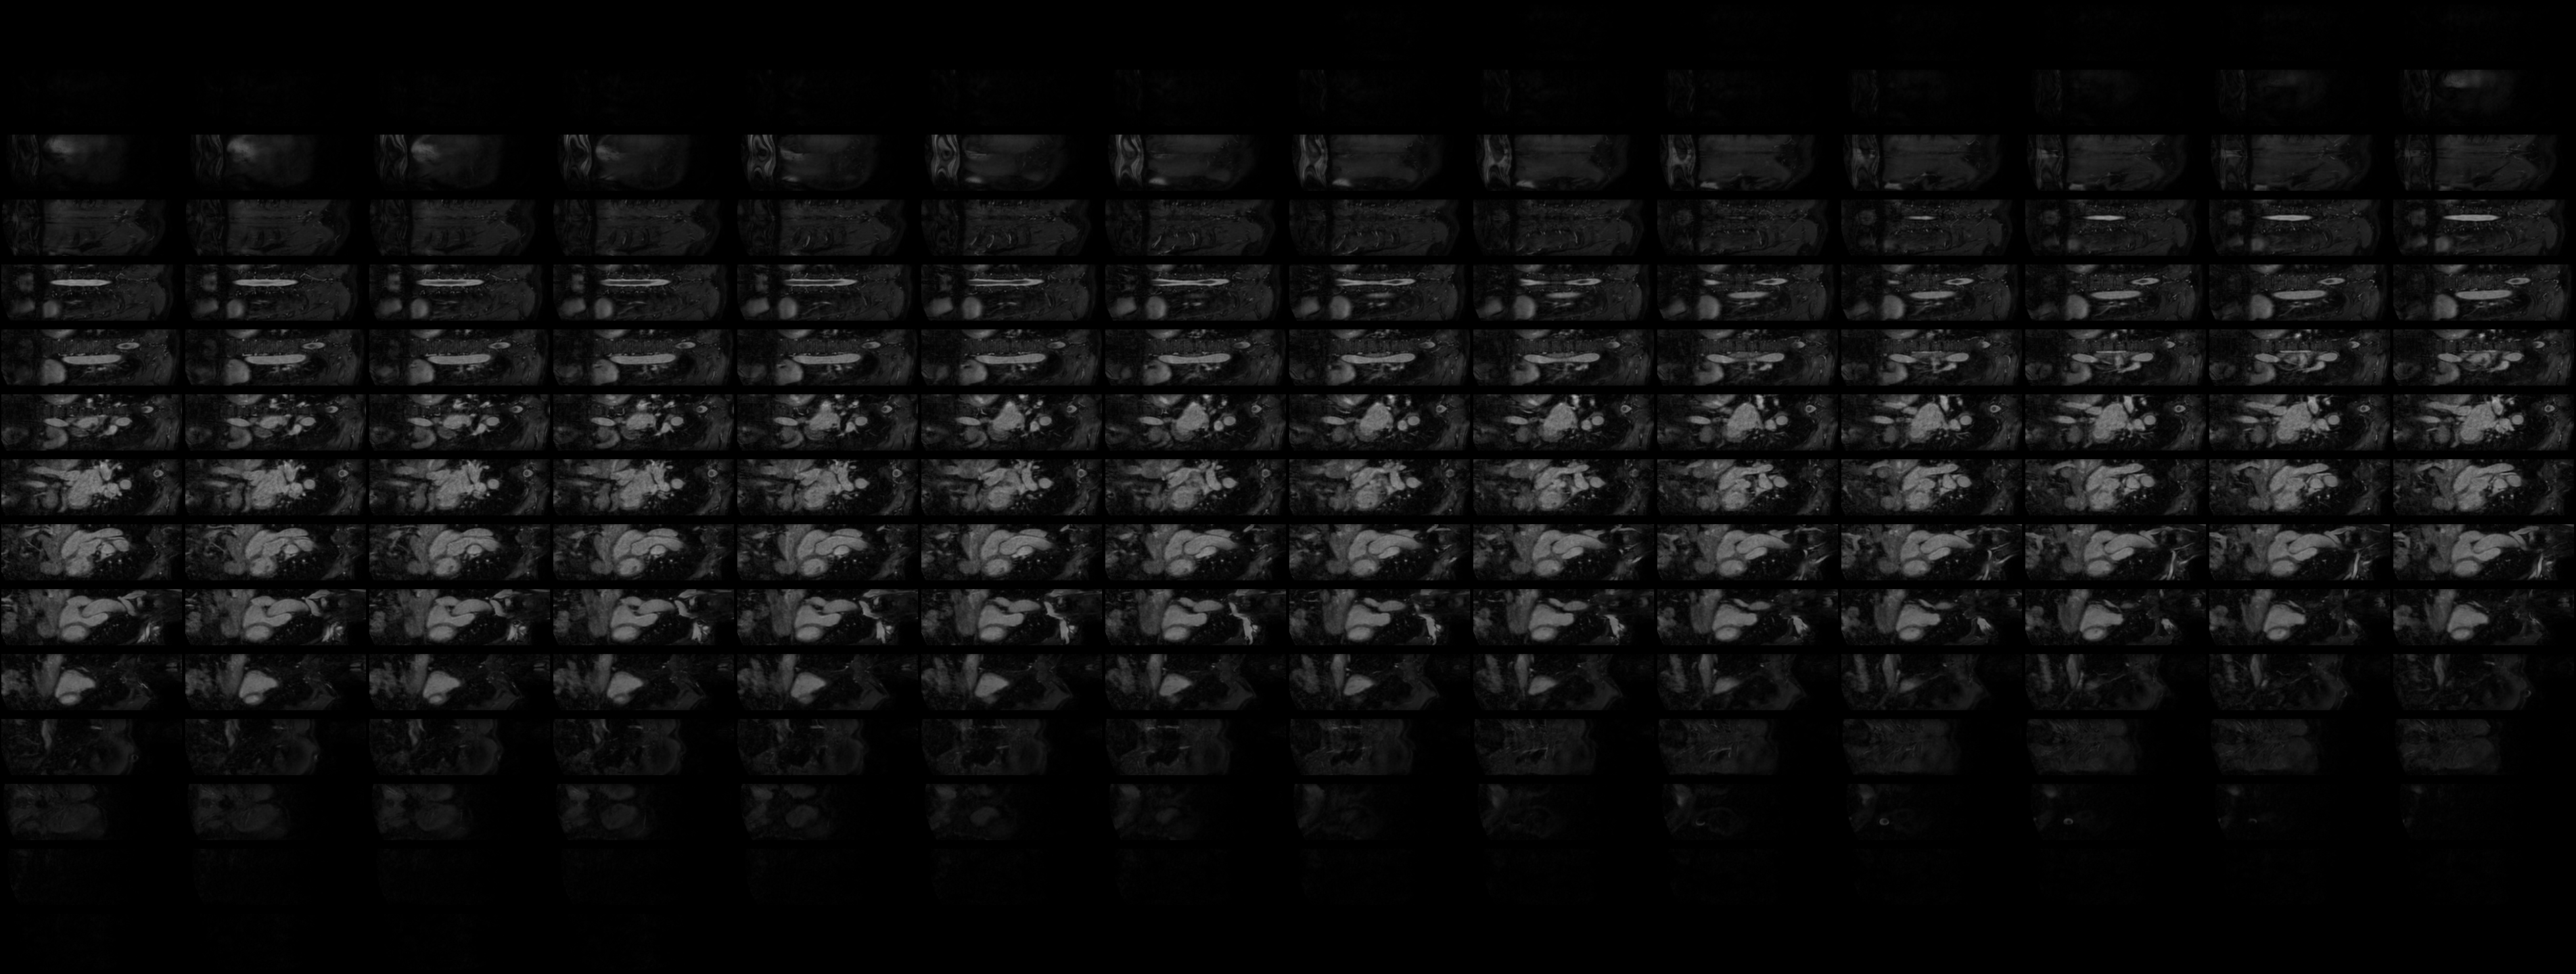
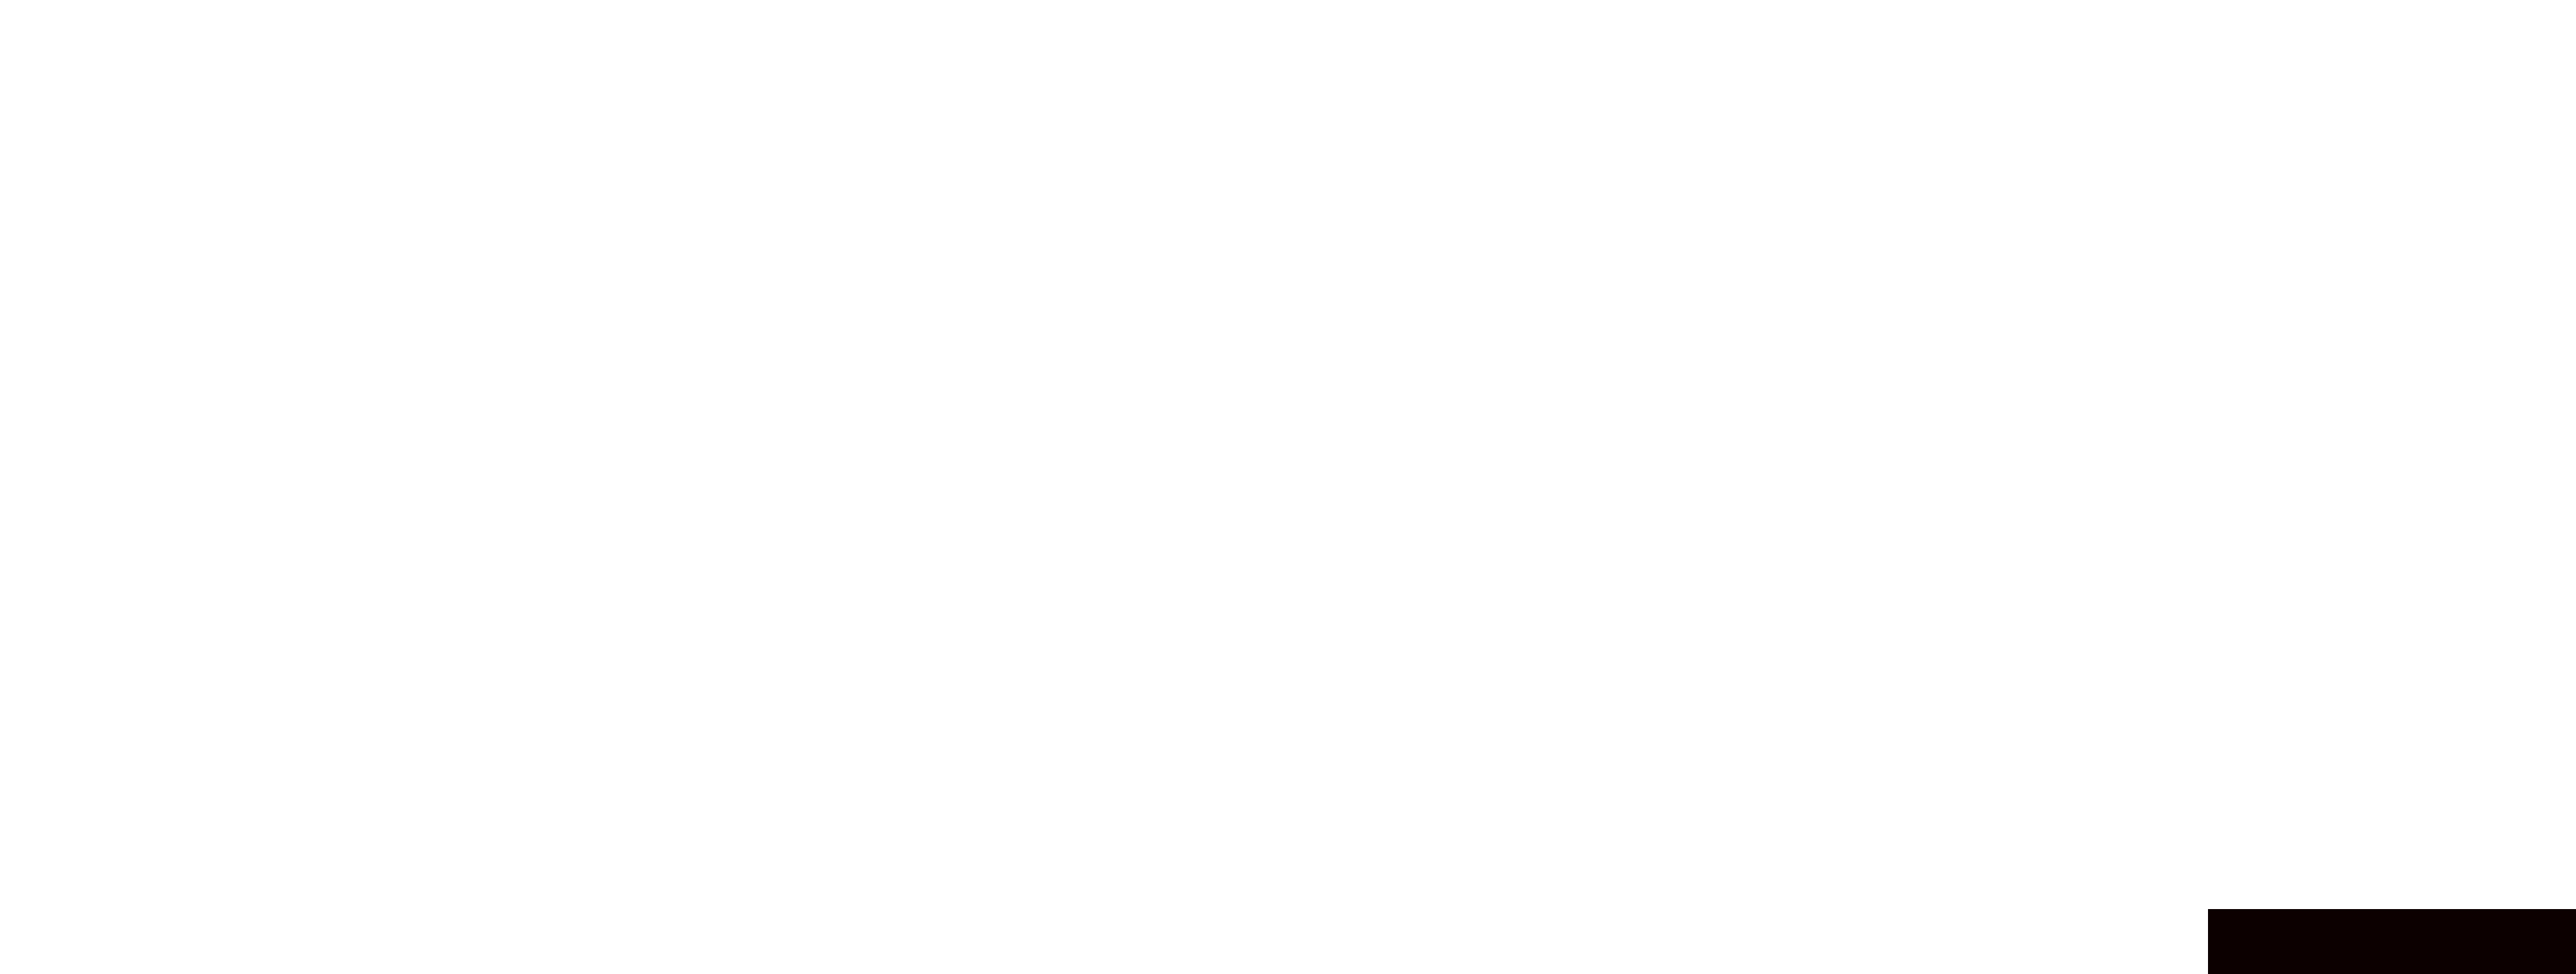

In [14]:
view = plotting.view_img(nifti_labels[0], bg_img=nifti_images[0])
view


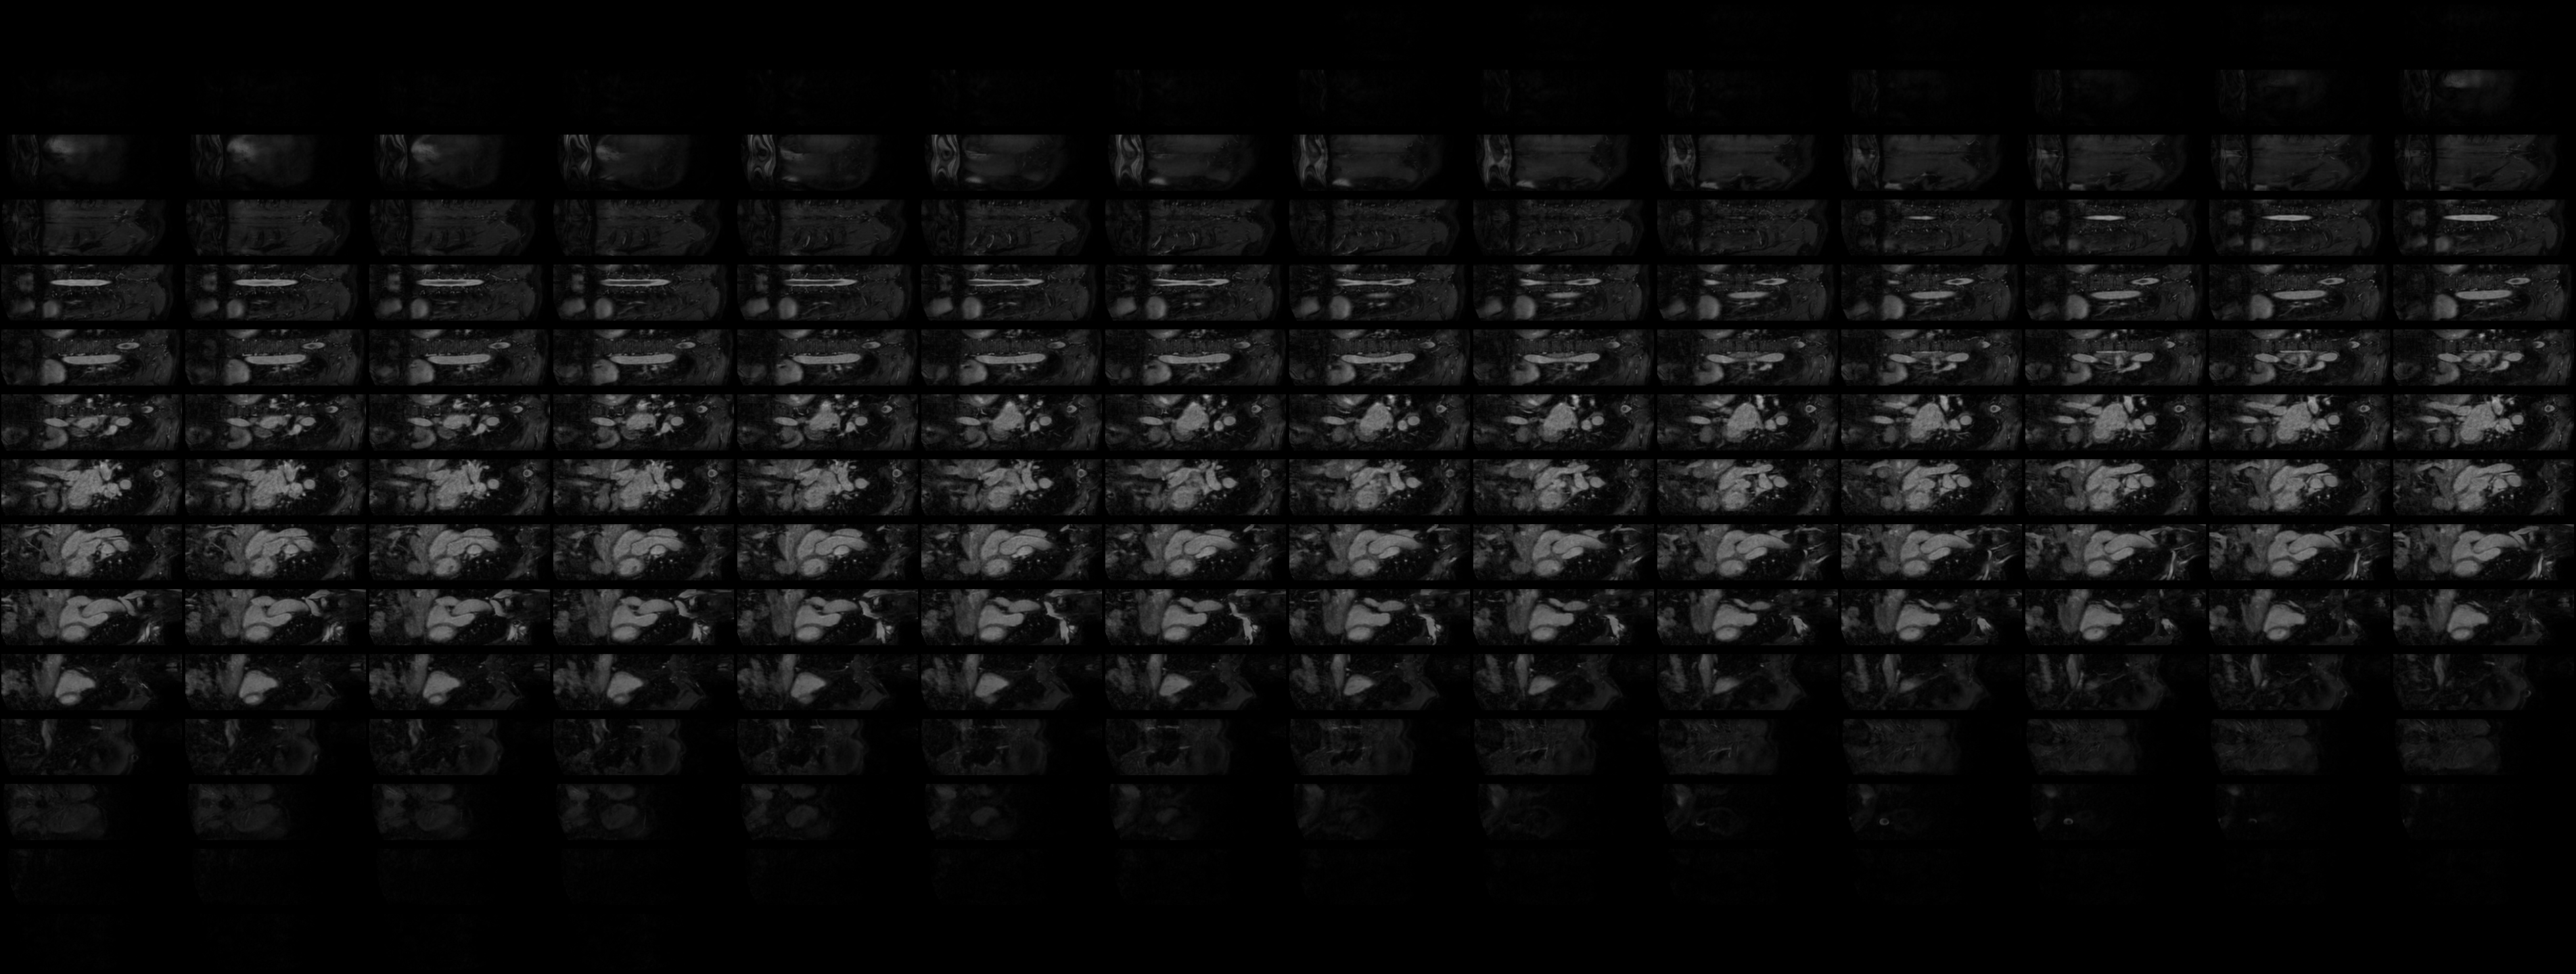
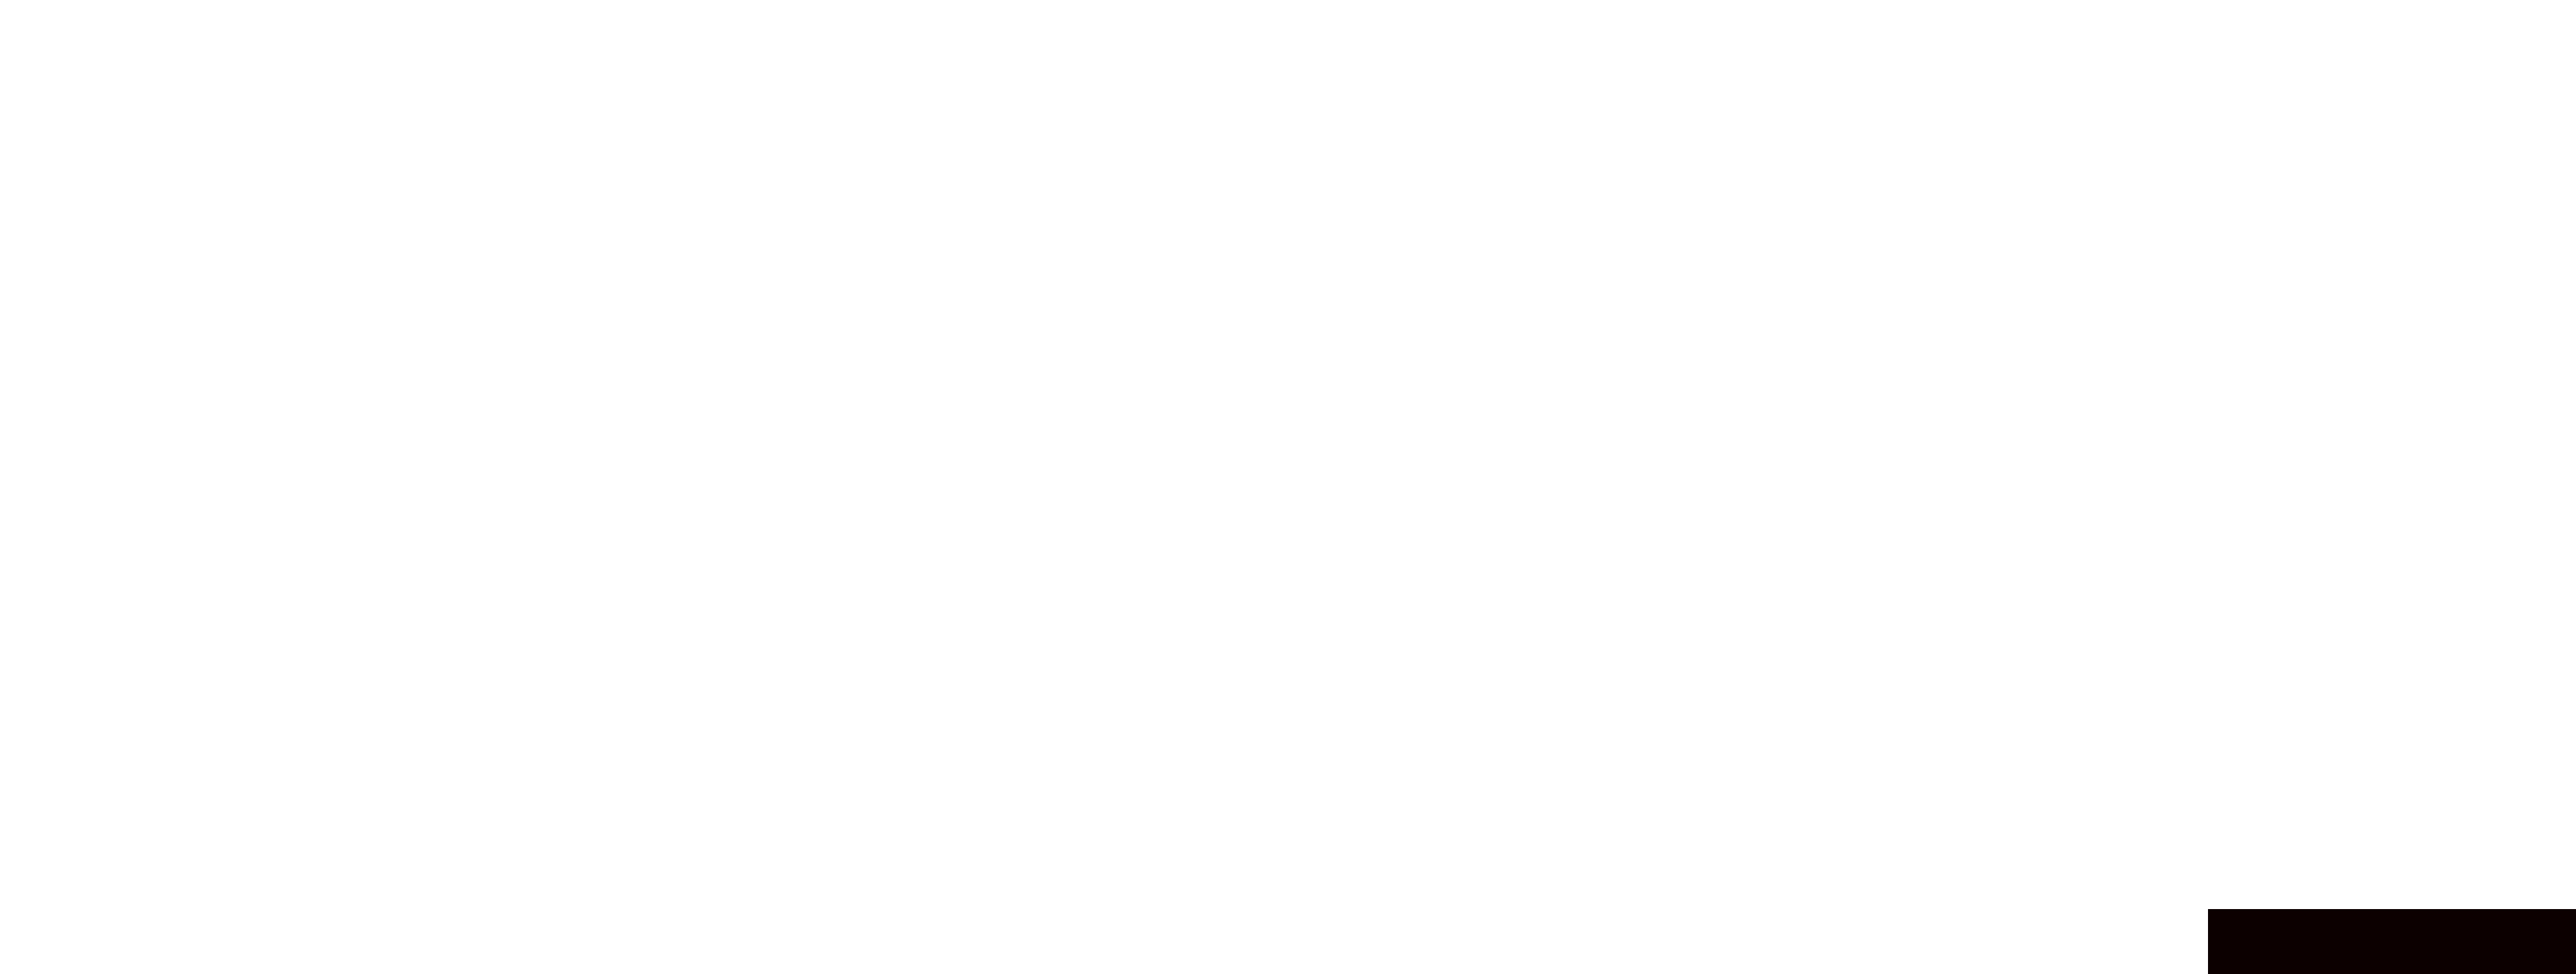

In [15]:
view = plotting.view_img(nifti_outputs[0], bg_img=nifti_images[0])
view

In [24]:
model.eval()
dice_scores = []
dice_metric = Dice(num_classes=2, average='macro').to(device)

with torch.no_grad():
    for test_data in test_loader:
        images = test_data['image'].to(device)
        labels = test_data['label'].to(device).int()
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        dice_score = dice_metric(preds, labels)
        dice_scores.append(dice_score.item())
    dice_score = sum(dice_scores) / len(dice_scores)
print(f"Average Dice Score: {dice_score:.4f}")

Average Dice Score: 0.7013
